# Modeling Stochastic Gradient Descent with SDEs
Eliott Van Dieren - 352934

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm,cholesky,eig

## (Q7) GD - SGD and SDE EM

In [2]:
n = 2; p = 2; x_0 = np.zeros(2)
np.random.seed(7302)
M = np.random.normal(0,1,size=(2,2))
y = np.random.normal(0,1,size=n)
T = 50 ; h = 2.0**(-np.arange(1,5))
K = np.floor(T/h).astype(int)

### Gradient Descent
$x^{k+1} = x^k - h \nabla f(x^k)$ where $f(x) = \frac{1}{2n}\|Mx-y\|^2$, 

which lands $\nabla f(x) = \frac{1}{n}M^\top(Mx-y)$

In [3]:
f = lambda M,x,y : 0.5*np.linalg.norm(M@x-y)**2/len(y)
grad_f = lambda M,x,y : M.T@(M@x-y)/len(y)

def gd(grad_f,f,h,K,M,y,x_0):
    x_gd = np.zeros((K,len(x_0)))
    x_gd[0,:] = x_0
    f_gd = np.zeros(K)
    f_gd[0] = f(M,x_0,y)
    for t in range(1,K):
        x_gd[t,:] = x_gd[t-1,:] - h*grad_f(M,x_gd[t-1,:],y)
        f_gd[t] = f(M,x_gd[t,:],y)
    return [x_gd,f_gd]

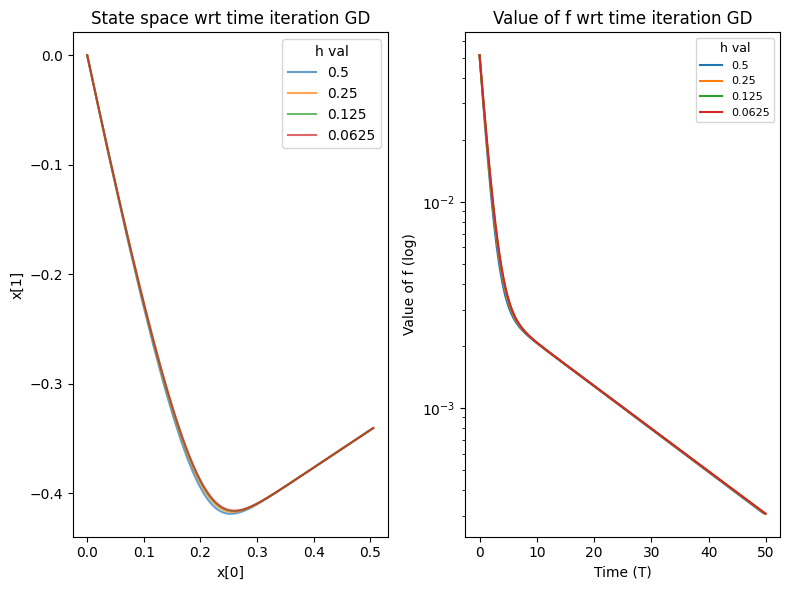

In [4]:
fig, ax = plt.subplots(1,2,figsize=(8,6))
for i in range(len(h)):
    x_gd,f_gd = gd(grad_f,f,h[i],K[i],M,y,x_0)
    # x plots
    ax[0].plot(x_gd[:,0],x_gd[:,1],label=str(h[i]),alpha=0.7)
    ax[0].set_title("State space wrt time iteration GD")
    ax[0].set_xlabel("x[0]")
    ax[0].set_ylabel("x[1]")
    ax[0].legend(title="h val")
    # f plots
    ax[1].plot(h[i]*np.arange(K[i]),f_gd,label=str(h[i]))
    ax[1].set_title("Value of f wrt time iteration GD")
    ax[1].set_xlabel("Time (T)")
    ax[1].set_ylabel("Value of f (log)")
    ax[1].set_yscale("log")
    ax[1].legend(title="h val",title_fontsize=9,fontsize=8)
plt.tight_layout()
#plt.savefig("GD_state_space_f.png")
plt.show()

### Stochastic Gradient Descent
If one supposes that $$f(x) = \frac{1}{n}\sum_{i=1}^nf_i(x),$$
the SGD gives us $x^{k+1} = x^k - h \nabla f_{i_k}(x^k)$ where $i_k \sim \operatorname{Uniform}(\{1,...,n\})$ and
$f_i(x) = \frac{1}{2n}|M_{i,\cdot}x-y_i|^2 \in \mathbb{R}$ 

which lands $\nabla f_i(x) = \frac{1}{n} M_{i,\cdot}^\top |M_{i,\cdot}x-y_i|$

Verification: $\nabla \frac{1}{2}\|M_{i,\cdot}x-y_i\|^2 = $
$$\nabla \frac{1}{2} |\sum_{j=1}^p M_{i,j}x_j-y_i|^2 = |M_{i,\cdot}x-y_i| \nabla |\sum_{j=1}^p M_{i,j}x_j-y_i| = |M_{i,\cdot}x-y_i| \frac{\sum_{j=1}^p M_{i,j}x_j-y_i}{|M_{i,\cdot}x-y_i|}M_{i,\cdot}^\top = M_{i,\cdot}^\top(M_{i,\cdot}x-y_i) \in \mathbb{R}^p$$

In [5]:
L = 8
def sgd(f,h,K,M,y,x_0):
    n,p = M.shape
    x_sgd = np.zeros((K,len(x_0)))
    x_sgd[0,:] = x_0
    f_sgd = np.zeros(K)
    f_sgd[0] = f(M,x_0,y)
    idx_grads = np.random.randint(low=0,high=n,size=K)
    for t in range(1,K):
        x_sgd[t,:] = x_sgd[t-1,:] - h*M[idx_grads[t],:]*(M[idx_grads[t],:]@x_sgd[t-1,:]-y[idx_grads[t]])
        f_sgd[t] = f(M,x_sgd[t,:],y)
    return [x_sgd,f_sgd]

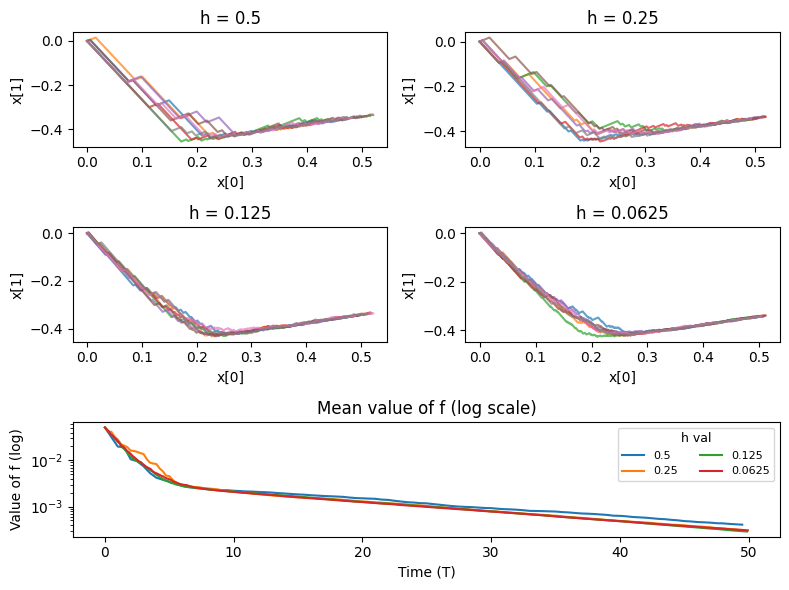

In [6]:
grid = (3, 2)
f_dict_sgd = {}
x_dict_sgd = {}
fig = plt.figure(figsize=(8, 6))
positions = [(0,0),(0,1),(1,0),(1,1),(2,0)]

# Computations
for idx in range(len(h)):
    f_tot = np.zeros(K[idx])
    for l in range(L):
        x_sgd,f_sgd = sgd(f,h[idx],K[idx],M,y,x_0)
        f_tot += f_sgd
        x_dict_sgd[str(h[idx])+'_'+str(l)] = x_sgd # storing x path
    f_tot /= L
    f_dict_sgd[h[idx]] = f_tot # storing mean of f_sgd

for i,pos in enumerate(positions[:-1]): 
    ax = plt.subplot2grid(grid, pos)
    for l in range(L):
        x = x_dict_sgd[str(h[i])+'_'+str(l)]
        ax.plot(x[:,0],x[:,1],label=str(h[i]),alpha=0.7)
    ax.set_title("h = "+str(h[i]))
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
# f plots
ax = plt.subplot2grid(grid, positions[-1],colspan=2)
for i in range(len(h)):
    ax.plot(h[i]*np.arange(K[i]),f_dict_sgd[h[i]],label=str(h[i]))
ax.set_title("Mean value of f (log scale)")
ax.set_xlabel("Time (T)")
ax.legend(loc='upper right',ncol=2,title="h val",title_fontsize=9,fontsize=8)
ax.set_ylabel("Value of f (log)")
ax.set_yscale("log")
fig.tight_layout()
#plt.savefig("SGD_state_space_f.png")
plt.show()

### Euler-Maruyama method for the SDE

Now, we solve
$$dX_t = - \nabla f(X_t)dt + \sqrt{h} \Sigma(X_t)^{\frac{1}{2}}dW_t \text{ where } \Sigma(x) = \frac{1}{n} M^\top \left[\operatorname{Diag}(R)^2-\frac{1}{n}RR^\top\right]M,$$ with $R = Mx-y$ and $[\operatorname{Diag}(R)^2]_{i,j} = \delta_{i,j}R^2_i$

By using the EM definition, we get:

$$X_{n+1} = - \nabla f(X_n) \Delta t + \sqrt{h} \Sigma(X_n)^{\frac{1}{2}} \Delta W_n$$

In [7]:
g = lambda M,x,y,R : M.T@(np.diag(R**2)-R@R.T/len(y))@M/len(y)
def EM(grad_f,f,g,h,K,M,y,x_0):
    n,p = M.shape
    x_em = np.zeros((K,2))
    x_em[0,:] = x_0
    f_em = np.zeros(K)
    f_em[0] = f(M,x_0,y)
    for t in range(1,K):
        #R = M@x_em[t-1,:]-y Change that to work with X_t instead of X tilde
        #qrt_sig = cholesky(g(M,x_em[t-1,:],y,R)) -> does not work
        # and sqrtm gives me imaginary numbers
        sqrt_sig = np.linalg.norm(M@x_em[t-1,:]-y)*M.T/len(y)
        x_em[t,:] = x_em[t-1,:] - h*grad_f(M,x_em[t-1,:],y) \
                    + np.sqrt(h)*sqrt_sig@np.random.normal(size=n)
        f_em[t] = f(M,x_em[t,:],y)
    return [x_em,f_em]

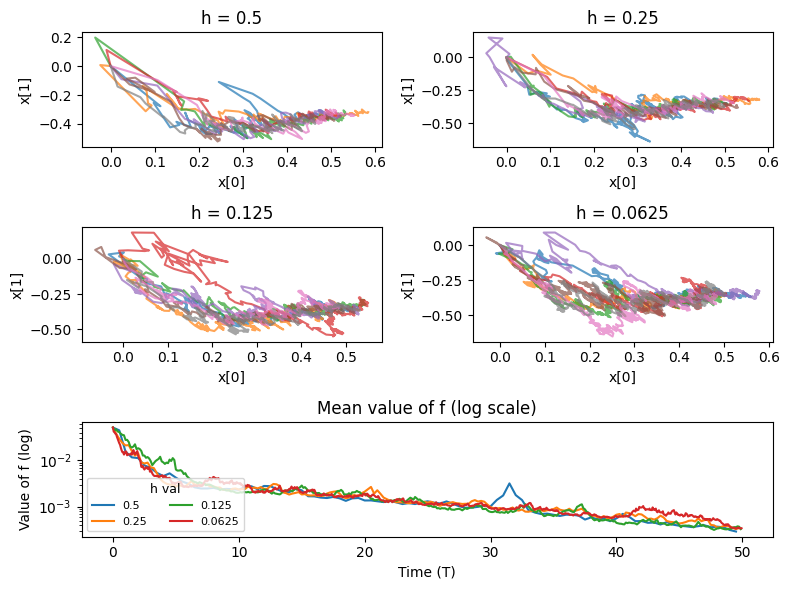

In [8]:
grid = (3, 2)
f_dict_em = {}
x_dict_em = {}
fig = plt.figure(figsize=(8, 6))
positions = [(0,0),(0,1),(1,0),(1,1),(2,0)]

# Computations
for idx in range(len(h)):
    f_tot = np.zeros(K[idx])
    for l in range(L):
        x_em,f_em = EM(grad_f,f,g,h[idx],K[idx],M,y,x_0)
        f_tot += f_em
        x_dict_em[str(h[idx])+'_'+str(l)] = x_em # storing x path
    f_tot /= L
    f_dict_em[h[idx]] = f_tot # storing mean of f_sgd

for i,pos in enumerate(positions[:-1]): 
    ax = plt.subplot2grid(grid, pos)
    for l in range(L):
        x = x_dict_em[str(h[i])+'_'+str(l)]
        ax.plot(x[:,0],x[:,1],label=str(h[i]),alpha=0.7)
    ax.set_title("h = "+str(h[i]))
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
# f plots
ax = plt.subplot2grid(grid, positions[-1],colspan=2)
for i in range(len(h)):
    ax.plot(h[i]*np.arange(K[i]),f_dict_em[h[i]],label=str(h[i]))
ax.set_title("Mean value of f (log scale)")
ax.set_xlabel("Time (T)")
ax.set_ylabel("Value of f (log)")
ax.set_yscale("log")
ax.legend(loc='lower left',ncol=2,title="h val",title_fontsize=9,fontsize=8)
fig.tight_layout()
#plt.savefig("EM_state_space_f.png")
plt.show()

# Q8 - Underparametrized system

In [9]:
n = 5; p = 2; x_0 = np.zeros(2)
np.random.seed(7302)
M = np.random.normal(0,1,size=(n,p))
y = np.random.chisquare(2,size=n)
T = 50 ; h = 2.0**(-np.arange(1,5))
K = np.floor(T/h).astype(int)

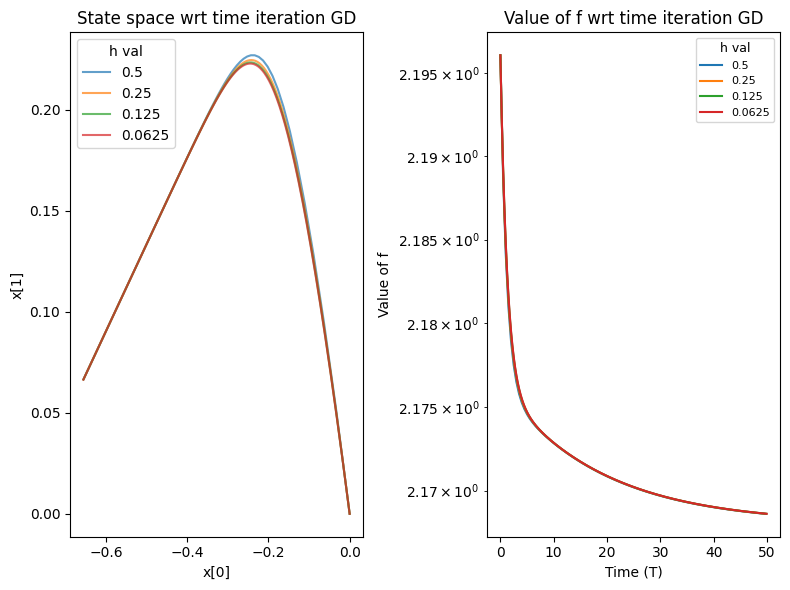

In [10]:
fig, ax = plt.subplots(1,2,figsize=(8,6))
for i in range(len(h)):
    x_gd,f_gd = gd(grad_f,f,h[i],K[i],M,y,x_0)
    # x plots
    ax[0].plot(x_gd[:,0],x_gd[:,1],label=str(h[i]),alpha=0.7)
    ax[0].set_title("State space wrt time iteration GD")
    ax[0].set_xlabel("x[0]")
    ax[0].set_ylabel("x[1]")
    ax[0].legend(title="h val")
    # f plots
    ax[1].plot(h[i]*np.arange(K[i]),f_gd,label=str(h[i]))
    ax[1].set_title("Value of f wrt time iteration GD")
    ax[1].set_xlabel("Time (T)")
    ax[1].set_ylabel("Value of f")
    ax[1].set_yscale("log")
    ax[1].legend(title="h val",title_fontsize=9,fontsize=8)
plt.tight_layout()
#plt.savefig("Q8_GD_state_space_f.png")
plt.show()

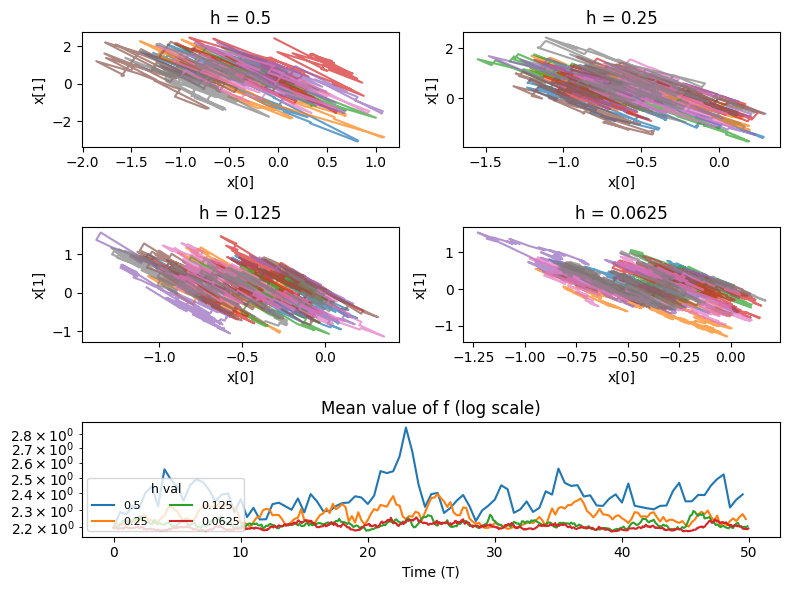

In [11]:
grid = (3, 2)
f_dict_sgd = {}
x_dict_sgd = {}
fig = plt.figure(figsize=(8, 6))
positions = [(0,0),(0,1),(1,0),(1,1),(2,0)]

# Computations
for idx in range(len(h)):
    f_tot = np.zeros(K[idx])
    for l in range(L):
        x_sgd,f_sgd = sgd(f,h[idx],K[idx],M,y,x_0)
        f_tot += f_sgd
        x_dict_sgd[str(h[idx])+'_'+str(l)] = x_sgd # storing x path
    f_tot /= L
    f_dict_sgd[h[idx]] = f_tot # storing mean of f_sgd

for i,pos in enumerate(positions[:-1]): 
    ax = plt.subplot2grid(grid, pos)
    for l in range(L):
        x = x_dict_sgd[str(h[i])+'_'+str(l)]
        ax.plot(x[:,0],x[:,1],label=str(h[i]),alpha=0.7)
    ax.set_title("h = "+str(h[i]))
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
# f plots
ax = plt.subplot2grid(grid, positions[-1],colspan=2)
for i in range(len(h)):
    ax.plot(h[i]*np.arange(K[i]),f_dict_sgd[h[i]],label=str(h[i]))
ax.set_title("Mean value of f (log scale)")
ax.set_xlabel("Time (T)")
ax.legend(loc='lower left',ncol=2,title="h val",title_fontsize=9,fontsize=8)
ax.set_yscale("log")
fig.tight_layout()
#plt.savefig("Q8_SGD_state_space_f.png")
plt.show()

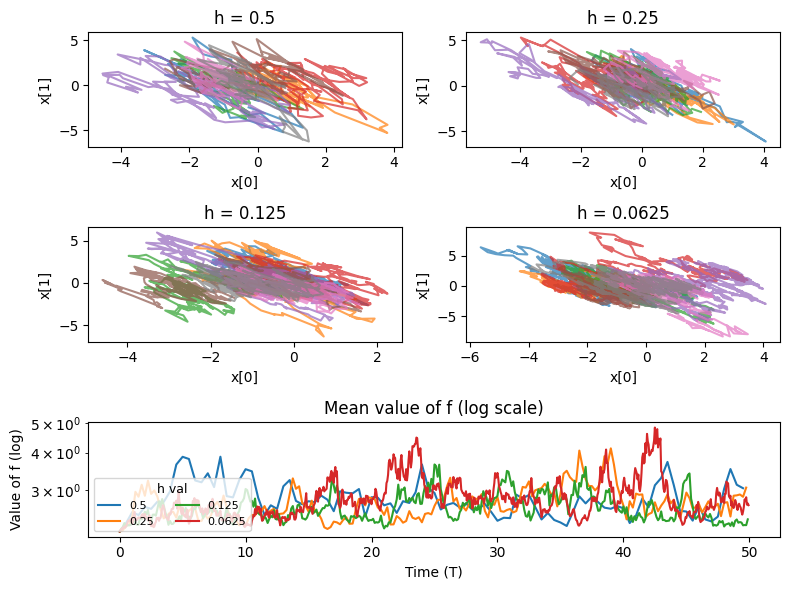

In [12]:
grid = (3, 2)
f_dict_em = {}
x_dict_em = {}
fig = plt.figure(figsize=(8, 6))
positions = [(0,0),(0,1),(1,0),(1,1),(2,0)]

# Computations
for idx in range(len(h)):
    f_tot = np.zeros(K[idx])
    for l in range(L):
        x_em,f_em = EM(grad_f,f,g,h[idx],K[idx],M,y,x_0)
        f_tot += f_em
        x_dict_em[str(h[idx])+'_'+str(l)] = x_em # storing x path
    f_tot /= L
    f_dict_em[h[idx]] = f_tot # storing mean of f_sgd

for i,pos in enumerate(positions[:-1]): 
    ax = plt.subplot2grid(grid, pos)
    for l in range(L):
        x = x_dict_em[str(h[i])+'_'+str(l)]
        ax.plot(x[:,0],x[:,1],label=str(h[i]),alpha=0.7)
    ax.set_title("h = "+str(h[i]))
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
# f plots
ax = plt.subplot2grid(grid, positions[-1],colspan=2)
for i in range(len(h)):
    ax.plot(h[i]*np.arange(K[i]),f_dict_em[h[i]],label=str(h[i]))
ax.set_title("Mean value of f (log scale)")
ax.set_xlabel("Time (T)")
ax.set_ylabel("Value of f (log)")
ax.set_yscale("log")
ax.legend(loc='lower left',ncol=2,title="h val",title_fontsize=9,fontsize=8)
fig.tight_layout()
#plt.savefig("Q8_EM_state_space_f.png")
plt.show()

### Verification convergence of state space

$f(x) = \frac{1}{2n}\|Mx-y\|^2$, which lands $\nabla f(x) = \frac{1}{n}M^\top(Mx-y)$.

one finds $x^* = (M^\top M)^{-1}M^\top y$

and 

$$d\widetilde{X}_t = - \nabla f(\widetilde{X}_t)dt + \sqrt{h} \tilde{\Sigma}(\widetilde{X}_t)^{\frac{1}{2}}dW_t \text{ where } \tilde{\Sigma}(x) = \frac{1}{n} M^\top \left[\frac{1}{n} \|Mx-y\|^2 I\right]M,$$ with $\widetilde{X}_0 = 0$.

By using the EM definition, we get:

$$\widetilde{X}_{n+1} =\widetilde{X}_{n} - \nabla f(\widetilde{X}_n) \Delta t + \sqrt{h} \tilde{\Sigma}(\widetilde{X}_n)^{\frac{1}{2}} \Delta W_n$$

In [13]:
x_opt = np.linalg.inv(M.T@M)@M.T@y
sig = lambda h,x_opt,f : 0.5*h*f(M,x_opt,y)
L = 1000

In [14]:
x_1_dict = {}
x_2_dict = {}
for idx in range(len(h)):
    x_1 = np.zeros(L)
    x_2 = np.zeros(L)
    for l in range(L):
        x_em,_ = EM(grad_f,f,g,h[idx],K[idx],M,y,x_0)
        x_1[l] = x_em[-1,0]
        x_2[l] = x_em[-1,1]
    x_1_dict[str(h[idx])] = x_1
    x_2_dict[str(h[idx])] = x_2

[]

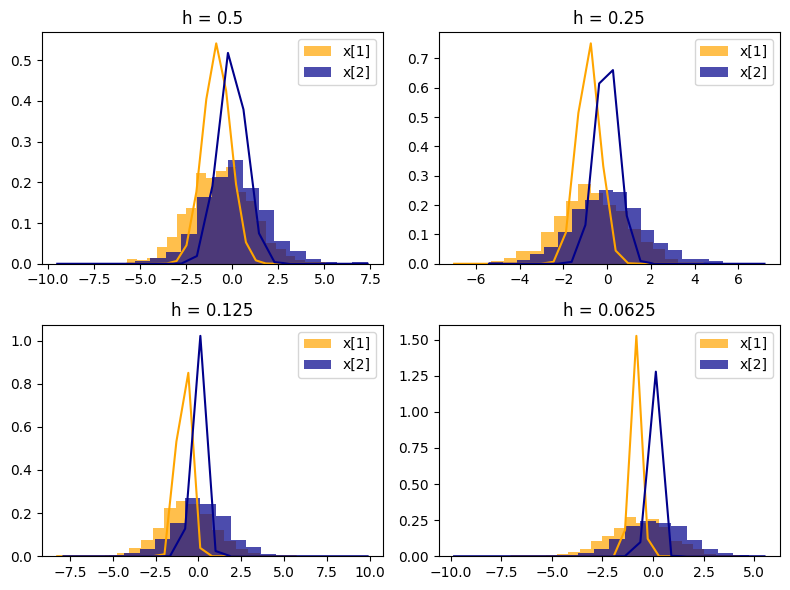

In [15]:
fig = plt.figure(figsize=(8, 6))
grid = (2,2)
for i,pos in enumerate(positions[:-1]): 
    var = sig(h[i],x_opt,f)
    ax = plt.subplot2grid(grid, pos)
    x_1 = x_1_dict[str(h[i])]
    x_2 = x_2_dict[str(h[i])]
    count_x_1, bins_x_1,_= ax.hist(x_1,label="x[1]",alpha=0.7,bins=20,density=True,color="orange")
    count_x_2, bins_x_2,_= ax.hist(x_2,label="x[2]",alpha=0.7,bins=20,density=True,color="darkblue")
    ax.plot(bins_x_1, 
            1/np.sqrt(2*np.pi*var)*np.exp(-(bins_x_1-x_opt[0])**2/(2*var)),
           color="orange")
    ax.plot(bins_x_2, 
            1/np.sqrt(2*np.pi*var)*np.exp(-(bins_x_2-x_opt[1])**2/(2*var)),
           color="darkblue")
    ax.legend()
    ax.set_title("h = "+str(h[i]))
plt.tight_layout()
#plt.savefig("x_tilde_convergence.png")
plt.plot()

# Q11 - Langevin equation

GD will stay the same as there is no randomness here and same obj function $f$

In [16]:
tau = 0.01
n = 2; p = 2; x_0 = np.zeros(2)
np.random.seed(7302)
M = np.random.normal(0,1,size=(2,2))
y = np.random.normal(0,1,size=n)
T = 50 ; h = 2.0**(-np.arange(1,5))
K = np.floor(T/h).astype(int)
L = 8

In [17]:
def ngd(f,h,K,M,y,x_0,tau):
    n,p = M.shape
    x_ngd = np.zeros((K,len(x_0)))
    x_ngd[0,:] = x_0
    f_ngd = np.zeros(K)
    f_ngd[0] = f(M,x_0,y)
    idx_grads = np.random.randint(low=0,high=n,size=K)
    for t in range(1,K):
        x_ngd[t,:] = x_ngd[t-1,:] - h*M[idx_grads[t],:]*(M[idx_grads[t],:]@x_ngd[t-1,:]-y[idx_grads[t]]) \
                    + np.sqrt(2*tau*h)*np.random.normal(size=p)
        f_ngd[t] = f(M,x_ngd[t,:],y)
    return [x_ngd,f_ngd]

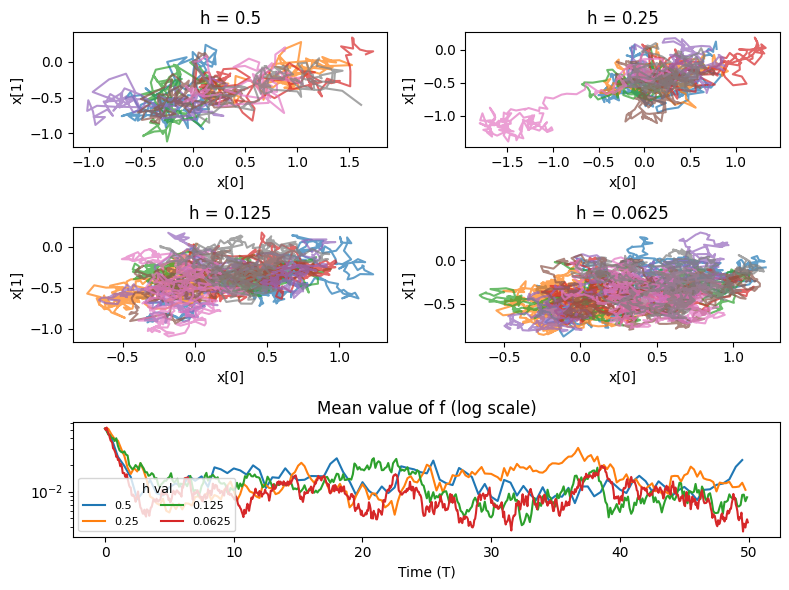

In [18]:
grid = (3, 2)
f_dict_ngd = {}
x_dict_ngd = {}
fig = plt.figure(figsize=(8, 6))
positions = [(0,0),(0,1),(1,0),(1,1),(2,0)]

# Computations
for idx in range(len(h)):
    f_tot = np.zeros(K[idx])
    for l in range(L):
        x_ngd,f_ngd = ngd(f,h[idx],K[idx],M,y,x_0,tau)
        f_tot += f_ngd
        x_dict_ngd[str(h[idx])+'_'+str(l)] = x_ngd # storing x path
    f_tot /= L
    f_dict_ngd[h[idx]] = f_tot # storing mean of f_sgd

for i,pos in enumerate(positions[:-1]): 
    ax = plt.subplot2grid(grid, pos)
    for l in range(L):
        x = x_dict_ngd[str(h[i])+'_'+str(l)]
        ax.plot(x[:,0],x[:,1],label=str(h[i]),alpha=0.7)
    ax.set_title("h = "+str(h[i]))
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
# f plots
ax = plt.subplot2grid(grid, positions[-1],colspan=2)
for i in range(len(h)):
    ax.plot(h[i]*np.arange(K[i]),f_dict_ngd[h[i]],label=str(h[i]))
ax.set_title("Mean value of f (log scale)")
ax.set_xlabel("Time (T)")
ax.legend(loc='lower left',ncol=2,title="h val",title_fontsize=9,fontsize=8)
ax.set_yscale("log")
fig.tight_layout()
#plt.savefig("Q11_NGD_state_space_f.png")
plt.show()

In [19]:
def EM_langevin(grad_f,f,h,K,M,y,x_0,tau):
    n,p = M.shape
    x_em = np.zeros((K,2))
    x_em[0,:] = x_0
    f_em = np.zeros(K)
    f_em[0] = f(M,x_0,y)
    for t in range(1,K):
        x_em[t,:] = x_em[t-1,:] - h*grad_f(M,x_em[t-1,:],y) \
                    + np.sqrt(2*tau*h)*np.random.normal(size=n)
        f_em[t] = f(M,x_em[t,:],y)
    return [x_em,f_em]

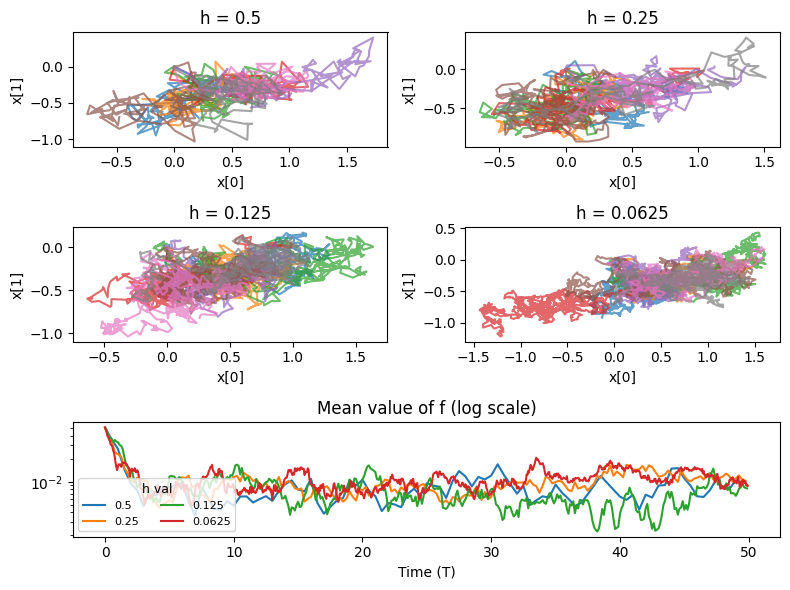

In [20]:
grid = (3, 2)
f_dict_em_l = {}
x_dict_em_l = {}
fig = plt.figure(figsize=(8, 6))
positions = [(0,0),(0,1),(1,0),(1,1),(2,0)]

# Computations
for idx in range(len(h)):
    f_tot = np.zeros(K[idx])
    for l in range(L):
        x_em_l,f_em_l = EM_langevin(grad_f,f,h[idx],K[idx],M,y,x_0,tau)
        f_tot += f_em_l
        x_dict_em_l[str(h[idx])+'_'+str(l)] = x_em_l # storing x path
    f_tot /= L
    f_dict_em_l[h[idx]] = f_tot # storing mean of f_sgd

for i,pos in enumerate(positions[:-1]): 
    ax = plt.subplot2grid(grid, pos)
    for l in range(L):
        x = x_dict_em_l[str(h[i])+'_'+str(l)]
        ax.plot(x[:,0],x[:,1],label=str(h[i]),alpha=0.7)
    ax.set_title("h = "+str(h[i]))
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
# f plots
ax = plt.subplot2grid(grid, positions[-1],colspan=2)
for i in range(len(h)):
    ax.plot(h[i]*np.arange(K[i]),f_dict_em_l[h[i]],label=str(h[i]))
ax.set_title("Mean value of f (log scale)")
ax.set_xlabel("Time (T)")
ax.legend(loc='lower left',ncol=2,title="h val",title_fontsize=9,fontsize=8)
ax.set_yscale("log")
fig.tight_layout()
#plt.savefig("Q11_EM_state_space_f.png")
plt.show()